In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline




In [2]:
# Set parameters for to match your MEIRLOP run and desired number of motifs
meirlop_output_directory = 'meirlop_output_directory'
n_top = 10
plot_title = f'Enrichment coefficients \n for top and bottom {n_top} significant motif enrichments'
barplot_filepath_prefix = f'meirlop_top_bottom_{n_top}_significant_barplot'

In [3]:

# Retrieve the logistic regression results
read_tsv = lambda filepath: pd.read_csv(filepath, sep = '\t')
lr_results_filepath = f'{meirlop_output_directory}/lr_results.tsv'
lr_results_df = read_tsv(lr_results_filepath)

# Get the significant results, filtered by the padj_sig column
lr_results_sig_df = lr_results_df[lr_results_df['padj_sig'] == 1].copy()
# Get the top significant motifs by enrichment coefficient
top_sig = list(lr_results_sig_df[(lr_results_sig_df['coef']).rank() <= n_top]['motif_id'])
# Get the bottom significant motifs by enrichment coefficient
bottom_sig = list(lr_results_sig_df[(-lr_results_sig_df['coef']).rank() <= n_top]['motif_id'])
# Combine the top and bottom significant motifs by enrichment coefficient
select_sig = top_sig + bottom_sig


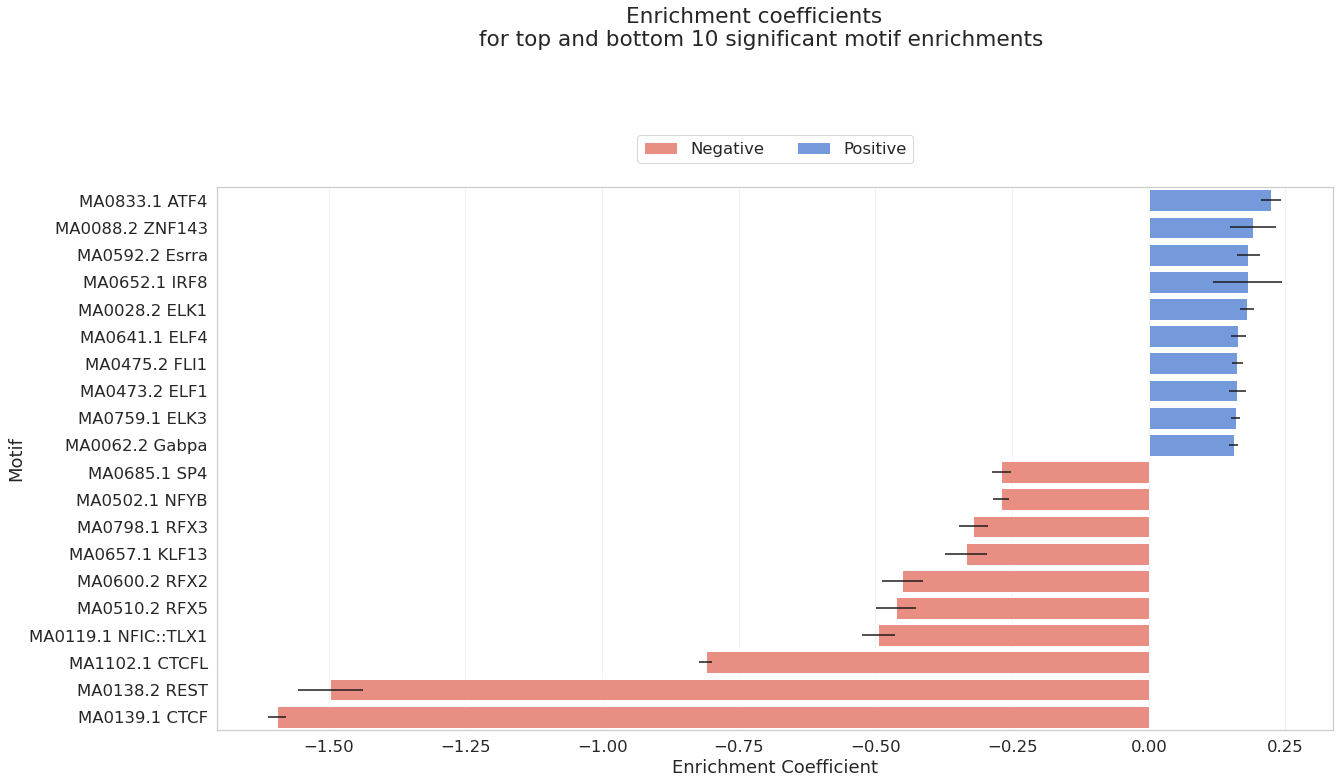

In [4]:
# Setup some plot aesthetics
sns.set()
plt.rcParams['grid.alpha'] = 0.25
plt.figure(figsize = (20, 10))
sns.set(font_scale = 1.5)
sns.set_style('whitegrid')

# Select just these top/bottom significant motifs, and their statistics
lr_results_select_df = lr_results_df[lr_results_df['motif_id'].isin(select_sig)].copy()
lr_results_select_df = lr_results_select_df.sort_values(by = 'coef', ascending = False)
lr_results_select_df['Motif'] = lr_results_select_df['motif_id']
lr_results_select_df['Enrichment Coefficient'] = lr_results_select_df['coef']

# Extract the 95% confidence intercals
coef_errs = (
    lr_results_select_df[
        [
            'ci_95_pct_lower', 
            'ci_95_pct_upper'
        ]
    ].apply(
        lambda x: x - lr_results_select_df['coef']
    )
    .abs()
    .T.values
)

# Label results by Enrichment coefficient direction
geq_to_legend = {
    True : 'Positive', 
    False : 'Negative'
}

lr_results_select_df['Enrichment Coefficient Direction'] = (
    lr_results_select_df['coef']
    .apply(lambda x: x >= 0.0)
    .map(geq_to_legend)
)

# Draw the plot
plt.suptitle(f'{plot_title}', y = 1.13)
ax = sns.barplot(
    x = lr_results_select_df['Enrichment Coefficient'], 
    y = lr_results_select_df['Motif'], 
    xerr = lr_results_select_df['std_err'], 
    hue = lr_results_select_df['Enrichment Coefficient Direction'],
    hue_order = [geq_to_legend[True], geq_to_legend[False]],
    palette = ['cornflowerblue', 'salmon'], dodge = False
)

# Draw the legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles=handles[::-1], 
    labels=labels[::-1], 
    ncol = 2, 
    loc = 'upper center', 
    bbox_to_anchor=(0.5, 1.11)
)

# Output figures to files
for fmt in ['svg', 'png']:
    plt.savefig(f'{barplot_filepath_prefix}.{fmt}', bbox_inches ='tight')